## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import re

from random import sample

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchsummary

from tqdm import tqdm
from plotly import express as ex
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = " ".join(text).lower().replace("\n","")

assert len(text) == 100224, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
import wget
def download(url: str, file: str):
    """
    Download file from <url>

    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        wget.download(url, file)
        print('Download Finished')

ModuleNotFoundError: No module named 'wget'

In [6]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt    
#download('https://raw.githubusercontent.com/attatrol/data_sources/master/', 'onegin.txt') 
with open('onegin.txt', 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]
text

['\n',
 'I\n',
 '\n',
 '«Мой дядя самых честных правил,\n',
 'Когда не в шутку занемог,\n',
 'Он уважать себя заставил\n',
 'И лучше выдумать не мог.\n',
 'Его пример другим наука;\n',
 'Но, боже мой, какая скука\n',
 'С больным сидеть и день и ночь,\n',
 'Не отходя ни шагу прочь!\n',
 'Какое низкое коварство\n',
 'Полуживого забавлять,\n',
 'Ему подушки поправлять,\n',
 'Печально подносить лекарство,\n',
 'Вздыхать и думать про себя:\n',
 'Когда же черт возьмет тебя!»\n',
 '\n',
 '\n',
 '\n',
 'II\n',
 '\n',
 'Так думал молодой повеса,\n',
 'Летя в пыли на почтовых,\n',
 'Всевышней волею Зевеса\n',
 'Наследник всех своих родных. —\n',
 'Друзья Людмилы и Руслана!\n',
 'С героем моего романа\n',
 'Без предисловий, сей же час\n',
 'Позвольте познакомить вас:\n',
 'Онегин, добрый мой приятель,\n',
 'Родился на брегах Невы,\n',
 'Где, может быть, родились вы\n',
 'Или блистали, мой читатель;\n',
 'Там некогда гулял и я:\n',
 'Но вреден север для меня\n',
 '\n',
 '\n',
 'III\n',
 '\n',
 'Сл

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = [re.sub("[^А-Яа-я ,-.]","",line.lower()) for line in text]
text = [line for line in text if line != ""]

Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
# My great code here
out = " ".join(text)
print(len(out))

tokens = sorted(set(out))

136144


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
# Your great code here
token_to_idx = {tokens[i]:i for i in range(len(tokens))}


# dict <char>:<index>
# Your great code here
idx_to_token = {i:tokens[i] for i in range(len(tokens))}

In [10]:
idx_to_token[len(token_to_idx)] = "<pad>"
token_to_idx["<pad>"] = len(token_to_idx)


vocab_size = len(token_to_idx)
print(vocab_size)

37


(array([4.200e+01, 5.186e+03, 2.800e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  2. ,  17.6,  33.2,  48.8,  64.4,  80. ,  95.6, 111.2, 126.8,
        142.4, 158. ]),
 <a list of 10 Patch objects>)

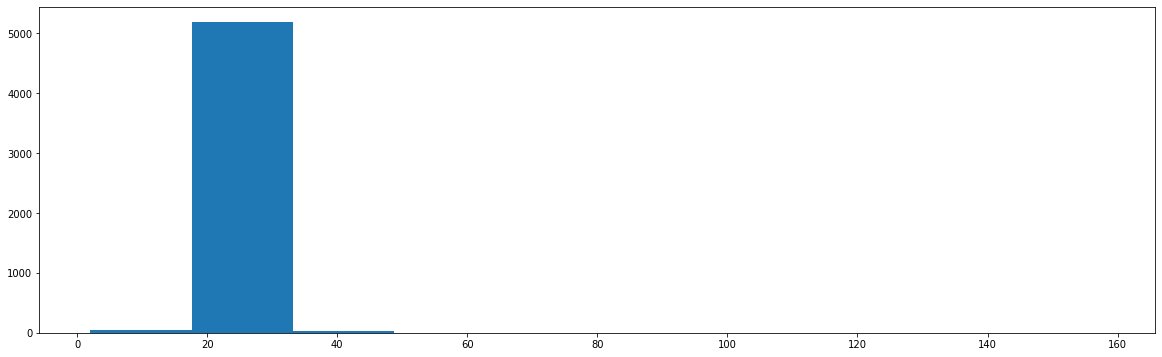

In [11]:
plt.figure(figsize=(20, 6))
plt.hist(x = [len(line) for line in text] )

In [12]:
seq_length = 30

In [13]:
print(idx_to_token)

{0: ' ', 1: ',', 2: '-', 3: '.', 4: 'а', 5: 'б', 6: 'в', 7: 'г', 8: 'д', 9: 'е', 10: 'ж', 11: 'з', 12: 'и', 13: 'й', 14: 'к', 15: 'л', 16: 'м', 17: 'н', 18: 'о', 19: 'п', 20: 'р', 21: 'с', 22: 'т', 23: 'у', 24: 'ф', 25: 'х', 26: 'ц', 27: 'ч', 28: 'ш', 29: 'щ', 30: 'ъ', 31: 'ы', 32: 'ь', 33: 'э', 34: 'ю', 35: 'я', 36: '<pad>'}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [14]:
# Your code here

In [15]:
def to_matrix(text, max_len=None, pad=token_to_idx['<pad>'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text))
    names_ix = np.zeros([len(text), max_len], dtype) + pad
    

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        line_ix = line_ix[:max_len]
        
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [16]:
X = to_matrix(text, max_len=seq_length)

In [17]:
print(X)
print(X.shape)

[[16 18 13 ... 12 15  1]
 [14 18  7 ... 36 36 36]
 [18 17  0 ... 36 36 36]
 ...
 [14 22 18 ... 36 36 36]
 [12  0  6 ... 12 16  1]
 [14  4 14 ... 36 36 36]]
(5257, 30)


In [18]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=vocab_size, embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)# YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next)# YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [19]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [20]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=seq_length, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(vocab_size,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [21]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (vocab_size,)

In [22]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to 
# get its view of desired shape.

loss = criterion(predictions_logp.contiguous().view(-1, vocab_size), 
                  actual_next_tokens.contiguous().view(-1))

In [23]:
loss.backward()

In [24]:
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())

In [25]:
# Define hyperparameters
char_rnn = CharRNNCell(num_tokens = vocab_size, embedding_size=128,rnn_num_units = 64 )

n_epochs = 3000
lr=0.001
batch_size = 128

# Define Loss, Optimizer
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=lr)

history = []

In [26]:
for i in tqdm(range(n_epochs)):
    batch_ix = to_matrix(sample(text, batch_size), max_len=seq_length)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[: ,1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, vocab_size),
        actual_next_tokens.contiguous().view(-1)
    )
    # YOUR CODE HERE 
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    
history = [h.reshape(-1)[0] for h in history]

# fig = ex.line(y=history, title='Loss')
# fig.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:55<00:00, 17.05it/s]


Plot the loss function (axis X: number of epochs, axis Y: loss function).

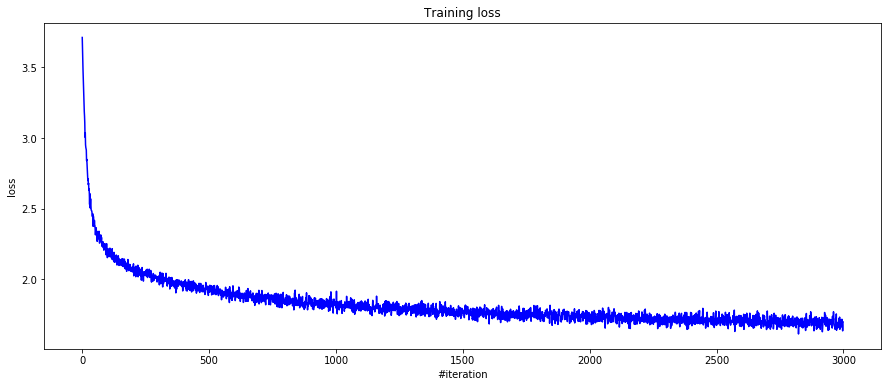

In [27]:
plt.figure(figsize=(15, 6))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(history, 'b')

In [48]:
# An example of generated text.

poem_length = 8
seed = "он"

for _ in range(poem_length) :
    generated_text = generate_sample(char_rnn, seed_phrase=seed, max_length=seq_length, temperature=0.1) 
    generated_text = generated_text.replace("<pad>","")
    seed = generated_text[-2]
    
    print(generated_text)

он в не своей полокой странит 
татьяна странной след не в не 
его в не своей послед
его странной странной странной
он в не стариков он в не своей
его поленья,
я странный странит он в не стр
татьяна света


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [28]:
# Your beautiful code here

In [113]:
num_tokens = vocab_size

In [114]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [115]:
batch_size = 128
epoch = 3000
lr = 0.001

In [116]:
model = CharRNNLoop(emb_size=128, rnn_num_units=64)
opt = torch.optim.Adam(model.parameters(), lr=lr)
history = []


In [117]:
MAX_LENGTH = seq_length

for i in tqdm(range(epoch)):
    batch_ix = to_matrix(sample(text, batch_size), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
        
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[: ,1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, vocab_size),
        actual_next_tokens.contiguous().view(-1)
    )
    # YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())

    
history = [h.reshape(-1)[0] for h in history]

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:06<00:00, 16.04it/s]


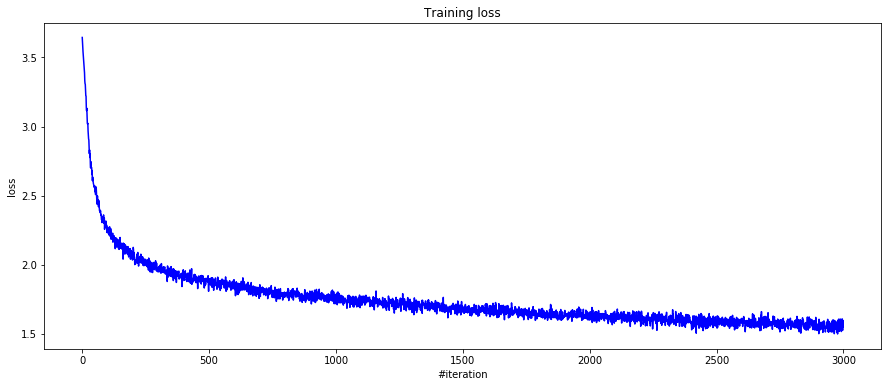

In [118]:
plt.figure(figsize=(15, 6))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(history, 'b')

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=seq_length, temperature=1.0):
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #seed phrase
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(vocab_size,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [191]:
seed = "  "
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
# temperatures = [0.1]
poem_length = 4
MAX_LENGTH = 30

In [194]:
poem = []

for temperature in temperatures :
    for line in range(poem_length) :
        x_seq = torch.tensor([[token_to_idx[c] for c in seed]], dtype=torch.int64) # set seed
        for i in range(MAX_LENGTH) :
            output = model.forward(x_seq)
            p_next = F.softmax(output / temperature, dim=-1).data.numpy()[0]
#             print(p_next)
            
            next_ix = np.random.choice(vocab_size,p=p_next[-1])
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_seq = torch.cat([x_seq, next_ix], dim=1)

        shedevr_line = "".join([idx_to_token[int(c)] for c in x_seq[0]]).replace("<pad>","").strip()
        poem.append(shedevr_line)
    poem.append("")

In [195]:
for line in poem :
    print(line)






с веренье на стариных,
полно пора после всех свет
постал на сердце полно
с волно после в сердце старины

с татьяна они, послевства.
пред ней совелась ваши странье
не мое стравно пол обрат
по то вашь пистил он странда

о-тадут бигда призная,
сей непрадых моего,
никак слушая, тами дузем
в чемор ромы будит. кона

елжизнаквиха аль. питны м ува.
лелсчурк умоюдыеза.-
осецнег легэк
доъ трисьей жжиная



### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [35]:
# Saving and loading code here

torch.save(model.state_dict(), "model.torch")

In [36]:

model.load_state_dict(torch.load("model.torch"))
model.eval()

CharRNNLoop(
  (emb): Embedding(37, 128)
  (rnn): LSTM(128, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=37, bias=True)
)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)